In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors


In [22]:
# Maze legend:
# 0 = free cell
# 1 = wall
# We'll set start and goal coordinates separately.
maze = [
    [0, 0, 0, 0],
    [1, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 1, 1, 0],
]
maze = np.array(maze)

start = (0, 0)
goal  = (3, 3)

actions = ['U', 'D', 'L', 'R']   # action order consistent with Q-table indices
rows, cols = maze.shape

print("Maze shape:", maze.shape)
print("Start:", start, "Goal:", goal)

Maze shape: (4, 4)
Start: (0, 0) Goal: (3, 3)


In [23]:
def is_valid_cell(r, c):
    """Return True if (r,c) is inside maze and not a wall."""
    if r < 0 or r >= rows or c < 0 or c >= cols:
        return False
    return maze[r, c] == 0

def step(state, action):
    """
    Take an action from state and return (next_state, reward, done_flag).
    Rewards:
      - invalid move or hitting wall: -1 (and stay in same state)
      - small step cost: -0.1
      - reaching goal: +10 and done=True
    """
    r, c = state
    if action == 'U':
        r2, c2 = r-1, c
    elif action == 'D':
        r2, c2 = r+1, c
    elif action == 'L':
        r2, c2 = r, c-1
    elif action == 'R':
        r2, c2 = r, c+1
    else:
        r2, c2 = r, c

    # invalid move
    if not is_valid_cell(r2, c2):
        return state, -1.0, False

    # valid move
    if (r2, c2) == goal:
        return (r2, c2), 10.0, True

    return (r2, c2), -0.1, False

def choose_action(state, Q, epsilon):
    """Epsilon-greedy: with probability epsilon choose random action, otherwise choose best (tie-broken randomly)."""
    if random.random() < epsilon:
        return random.choice(actions)
    else:
        r, c = state
        qvals = Q[r, c]
        # pick randomly among ties
        max_q = np.max(qvals)
        candidates = [i for i, q in enumerate(qvals) if np.isclose(q, max_q)]
        idx = random.choice(candidates)
        return actions[idx]

In [24]:
Q = np.zeros((rows, cols, len(actions)), dtype=float)

# Learning params
alpha = 0.7        # learning rate
gamma = 0.9        # discount factor
epsilon = 1.0      # start exploration prob
min_epsilon = 0.01
decay_rate = 0.001  # epsilon decay per episode (exponential decay recommended below)
episodes = 2000
max_steps_per_episode = 100

# Training
successes = 0
episode_rewards = []

for ep in range(episodes):
    state = start
    total_reward = 0.0
    done = False

    for step_i in range(max_steps_per_episode):
        action = choose_action(state, Q, epsilon)
        a_idx = actions.index(action)

        next_state, reward, done = step(state, action)
        total_reward += reward

        # Q-learning update
        r0, c0 = state
        r1, c1 = next_state
        best_next = np.max(Q[r1, c1])
        Q[r0, c0, a_idx] += alpha * (reward + gamma * best_next - Q[r0, c0, a_idx])

        state = next_state
        if done:
            successes += 1
            break

    # decay epsilon (exponential decay)
    epsilon = max(min_epsilon, epsilon * np.exp(-decay_rate * ep))
    episode_rewards.append(total_reward)

    # logging every 200 episodes
    if (ep+1) % 200 == 0:
        recent_success_rate = successes / (ep+1)
        avg_reward = np.mean(episode_rewards[-200:])
        print(f"Episode {ep+1}/{episodes}  AvgReward(last200)={avg_reward:.3f}  SuccessRate_sofar={recent_success_rate:.3f}  Epsilon={epsilon:.3f}")

print("Training finished.")
print(f"Total successes (episodes reaching goal): {successes}/{episodes}")

Episode 200/2000  AvgReward(last200)=5.193  SuccessRate_sofar=0.975  Epsilon=0.010
Episode 400/2000  AvgReward(last200)=9.456  SuccessRate_sofar=0.988  Epsilon=0.010
Episode 600/2000  AvgReward(last200)=9.446  SuccessRate_sofar=0.992  Epsilon=0.010
Episode 800/2000  AvgReward(last200)=9.482  SuccessRate_sofar=0.994  Epsilon=0.010
Episode 1000/2000  AvgReward(last200)=9.450  SuccessRate_sofar=0.995  Epsilon=0.010
Episode 1200/2000  AvgReward(last200)=9.452  SuccessRate_sofar=0.996  Epsilon=0.010
Episode 1400/2000  AvgReward(last200)=9.488  SuccessRate_sofar=0.996  Epsilon=0.010
Episode 1600/2000  AvgReward(last200)=9.467  SuccessRate_sofar=0.997  Epsilon=0.010
Episode 1800/2000  AvgReward(last200)=9.466  SuccessRate_sofar=0.997  Epsilon=0.010
Episode 2000/2000  AvgReward(last200)=9.487  SuccessRate_sofar=0.998  Epsilon=0.010
Training finished.
Total successes (episodes reaching goal): 1995/2000


In [25]:
np.set_printoptions(precision=2, suppress=True)
print("Q-values (per cell, action order U,D,L,R):")
for r in range(rows):
    for c in range(cols):
        if maze[r, c] == 0:
            print(f"Cell {(r,c)}: {Q[r,c]}")
        else:
            print(f"Cell {(r,c)}: WALL")

# Greedy policy (choose best action, tie-broken randomly)
policy = np.full((rows, cols), '', dtype=object)
for r in range(rows):
    for c in range(cols):
        if maze[r,c] == 1:
            policy[r,c] = 'W'   # wall
        elif (r,c) == goal:
            policy[r,c] = 'G'
        else:
            best_idx = int(np.argmax(Q[r,c]))
            policy[r,c] = actions[best_idx]

print("\nGreedy policy map:")
for row in policy:
    print(' '.join([f"{x:>2}" for x in row]))

Q-values (per cell, action order U,D,L,R):
Cell (0, 0): [3.95 3.95 3.95 5.5 ]
Cell (0, 1): [4.6  4.6  4.85 6.22]
Cell (0, 2): [5.32 7.02 5.5  5.5 ]
Cell (0, 3): [4.59 4.6  6.22 4.59]
Cell (1, 0): WALL
Cell (1, 1): WALL
Cell (1, 2): [6.22 7.91 6.12 6.12]
Cell (1, 3): WALL
Cell (2, 0): [5.32 5.49 5.32 7.02]
Cell (2, 1): [6.12 6.12 6.22 7.91]
Cell (2, 2): [7.02 7.01 7.02 8.9 ]
Cell (2, 3): [ 8.   10.    7.91  8.  ]
Cell (3, 0): [6.22 4.59 4.58 4.55]
Cell (3, 1): WALL
Cell (3, 2): WALL
Cell (3, 3): [0. 0. 0. 0.]

Greedy policy map:
 R  R  D  L
 W  W  D  W
 R  R  R  D
 U  W  W  G


In [26]:
state = start
path = [state]
visited = set([state])
max_test_steps = 100
done = False

for _ in range(max_test_steps):
    r, c = state
    if maze[r,c] == 1:
        print("Hit a wall unexpectedly at", state)
        break
    if state == goal:
        done = True
        break
    # choose best action (tie-break random)
    qvals = Q[r, c]
    best_q = np.max(qvals)
    candidates = [i for i, q in enumerate(qvals) if np.isclose(q, best_q)]
    a_idx = random.choice(candidates)
    action = actions[a_idx]
    next_state, reward, reached = step(state, action)
    path.append(next_state)
    state = next_state
    if state in visited:
        # loop detected
        print("Loop detected, stopping test run.")
        break
    visited.add(state)
    if reached:
        done = True
        break

print("Test run success:", done)
print("Path taken:", path)

Test run success: True
Path taken: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (3, 3)]


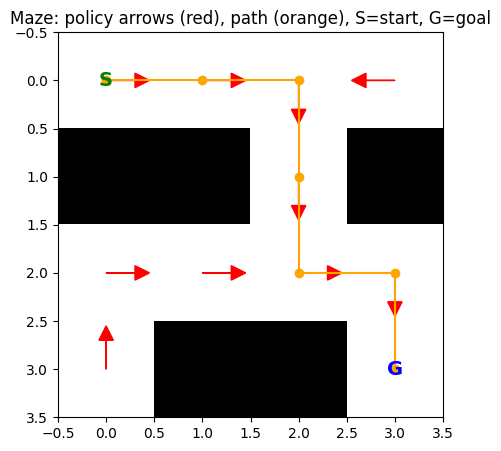

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
cmap = colors.ListedColormap(['white', 'black'])
ax.imshow(maze, cmap=cmap, origin='upper')

# draw grid
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)

# arrows for policy
dx = {'U':0, 'D':0, 'L':-1, 'R':1}
dy = {'U':-1,'D':1,'L':0,'R':0}
for r in range(rows):
    for c in range(cols):
        if maze[r,c] == 0 and (r,c) != goal:
            a = policy[r,c]
            if a in actions:
                ax.arrow(c, r, dx[a]*0.3, dy[a]*0.3, head_width=0.15, head_length=0.15, fc='red', ec='red')

# plot start and goal
ax.text(start[1], start[0], 'S', ha='center', va='center', color='green', fontsize=14, fontweight='bold')
ax.text(goal[1], goal[0], 'G', ha='center', va='center', color='blue', fontsize=14, fontweight='bold')

# plot path
if len(path) > 0:
    px = [p[1] for p in path]
    py = [p[0] for p in path]
    ax.plot(px, py, marker='o', color='orange')

ax.set_title('Maze: policy arrows (red), path (orange), S=start, G=goal')
ax.set_xlim(-0.5, cols-0.5)
ax.set_ylim(rows-0.5, -0.5)
plt.show()

In [28]:
import numpy as np
import random

# Maze: 0 = free, 1 = wall, S = start, G = goal
maze = [
    [0, 0, 0, 0],
    [1, 1, 0, 1],
    [0, 0, 0, 0],
    [0, 1, 1, 0],
]
start = (0, 0)
goal = (3, 3)

# Actions: up, down, left, right
actions = ['U', 'D', 'L', 'R']
rows, cols = len(maze), len(maze[0])
Q = np.zeros((rows, cols, len(actions)))  # Q-table

# Learning parameters
alpha = 0.7       # learning rate
gamma = 0.9       # discount factor
epsilon = 0.9     # exploration rate
episodes = 500

# Step function
def step(state, action):
    r, c = state
    if action == 'U': r -= 1
    if action == 'D': r += 1
    if action == 'L': c -= 1
    if action == 'R': c += 1
    # Check bounds and walls
    if r < 0 or r >= rows or c < 0 or c >= cols or maze[r][c] == 1:
        return state, -1  # invalid move penalty
    if (r, c) == goal:
        return (r, c), 10  # reward for goal
    return (r, c), -0.1   # small negative reward

# Training
for _ in range(episodes):
    state = start
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # explore
        else:
            action = actions[np.argmax(Q[state[0], state[1]])]  # exploit

        next_state, reward = step(state, action)
        a_idx = actions.index(action)
        best_next = np.max(Q[next_state[0], next_state[1]])

        # Q-learning update
        Q[state[0], state[1], a_idx] += alpha * (reward + gamma * best_next - Q[state[0], state[1], a_idx])
        state = next_state

# Test run (greedy)
state = start
path = [state]
while state != goal:
    action = actions[np.argmax(Q[state[0], state[1]])]
    state, _ = step(state, action)
    path.append(state)

print("Learned path:")
print(path)

Learned path:
[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (3, 3)]
